In [0]:
#read the dataset
df = spark.read.format('csv')\
    .option('header','true')\
        .option('inferschema','true')\
            .load('/FileStore/tables/credit_card_transactions.csv')
df.show(3)

+----------+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+-------------+
|Unnamed: 0|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|merch_zipcode|
+----------+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+-------------+
|         0|  2019-01-01 00:00:18|2703186189652095|fraud_Rippin,

In [0]:
#print schema
df.printSchema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_zipcode: integer (nullable = true)



In [0]:
from pyspark.sql.functions import *
#check null values
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()


+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+
|Unnamed: 0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|merch_zipcode|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+
|         0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|       195973|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+



In [0]:
#extract day of week, month, year, time of day
df.select(col("trans_date_trans_time")).show(5)
#transformations
df = df.withColumn("day_of_week", dayofweek(col("trans_date_trans_time")))  # 1 = Sunday, 7 = Saturday
df = df.withColumn("month", month(col("trans_date_trans_time")))
df = df.withColumn("year", year(col("trans_date_trans_time")))
df = df.withColumn("hour", hour(col("trans_date_trans_time")))

df.select(col("day_of_week"),col("month"),col("year"),col("hour")).show(5)

+---------------------+
|trans_date_trans_time|
+---------------------+
|  2019-01-01 00:00:18|
|  2019-01-01 00:00:44|
|  2019-01-01 00:00:51|
|  2019-01-01 00:01:16|
|  2019-01-01 00:03:06|
+---------------------+
only showing top 5 rows

+-----------+-----+----+----+
|day_of_week|month|year|hour|
+-----------+-----+----+----+
|          3|    1|2019|   0|
|          3|    1|2019|   0|
|          3|    1|2019|   0|
|          3|    1|2019|   0|
|          3|    1|2019|   0|
+-----------+-----+----+----+
only showing top 5 rows



In [0]:
#analyze fraud by hour of day
df_fraud_hour = df.filter(col("is_fraud") == 1).groupBy("hour").agg(count(col("is_fraud")).alias("fraud_count_by_ht"))
df_fraud_hour.sort(col("fraud_count_by_ht").desc()).show(15)

#convert dataframe into pandas df for visualization
import matplotlib.pyplot as plt 
df_fraud_hour = df_fraud_hour.toPandas()

+----+-----------------+
|hour|fraud_count_by_ht|
+----+-----------------+
|  22|             1931|
|  23|             1904|
|   1|              658|
|   0|              635|
|   2|              625|
|   3|              609|
|  14|               86|
|  19|               81|
|  18|               81|
|  13|               80|
|  15|               79|
|  17|               78|
|  16|               76|
|  21|               74|
|  12|               67|
+----+-----------------+
only showing top 15 rows



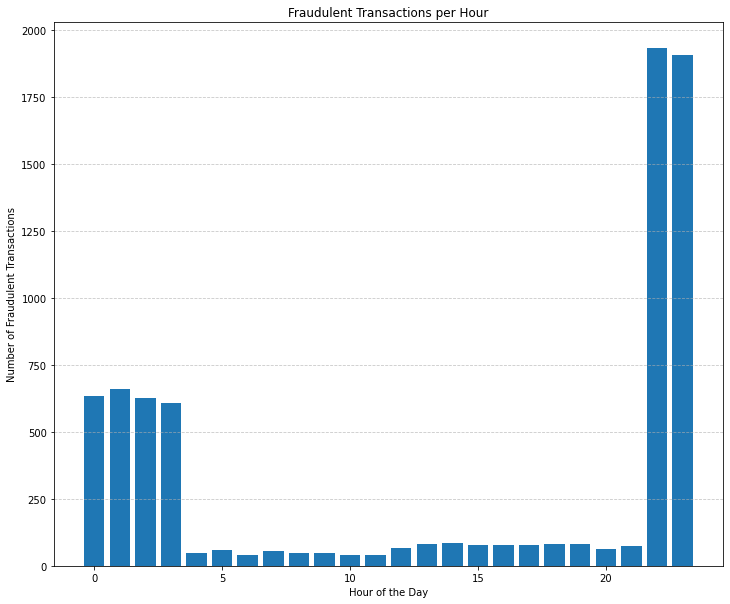

In [0]:
# Set figure size before plotting
plt.figure(figsize=(12, 10))

# Plot the bar chart
plt.bar(data = df_fraud_hour, x = 'hour', height = 'fraud_count_by_ht')
# Show the plot
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Fraudulent Transactions per Hour")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [0]:
#analyze fraud by month 
df_fraud_month = df.filter(col("is_fraud") == 1).groupBy("month").agg(count(col("is_fraud"))\
    .alias("fraud_count_by_month"))
df_fraud_month.sort(col("fraud_count_by_month").desc()).show()
#convert into pandas df
df_fraud_month = df_fraud_month.toPandas()
df_fraud_month.head()


+-----+--------------------+
|month|fraud_count_by_month|
+-----+--------------------+
|    3|                 938|
|    5|                 935|
|    2|                 853|
|    1|                 849|
|    6|                 688|
|    4|                 678|
|   12|                 592|
|   10|                 454|
|    9|                 418|
|   11|                 388|
|    8|                 382|
|    7|                 331|
+-----+--------------------+



,month,fraud_count_by_month
0,1,849
1,3,938
2,2,853
3,6,688
4,5,935


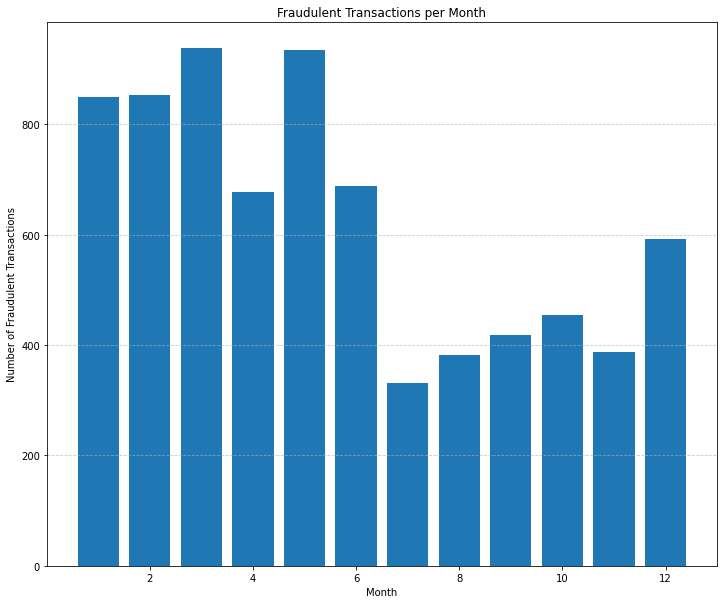

In [0]:
# Set figure size before plotting
plt.figure(figsize=(12, 10))

# Plot the bar chart
plt.bar(data = df_fraud_month, x = 'month', height = 'fraud_count_by_month')
# Show the plot
plt.xlabel("Month")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Fraudulent Transactions per Month")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [0]:
#analyze fraud by day of week
df_fraud_by_day = df.filter(col("is_fraud") == 1).groupBy("day_of_week").agg(count(col("is_fraud"))\
    .alias("fraud_count_by_day"))
df_fraud_by_day.sort(col("fraud_count_by_day").desc()).show()
#convert into pandas df
df_fraud_by_day = df_fraud_by_day.toPandas()
df_fraud_by_day.head()


+-----------+------------------+
|day_of_week|fraud_count_by_day|
+-----------+------------------+
|          7|              1227|
|          1|              1216|
|          2|              1182|
|          6|              1079|
|          5|              1008|
|          3|               935|
|          4|               859|
+-----------+------------------+



,day_of_week,fraud_count_by_day
0,1,1216
1,6,1079
2,3,935
3,5,1008
4,4,859


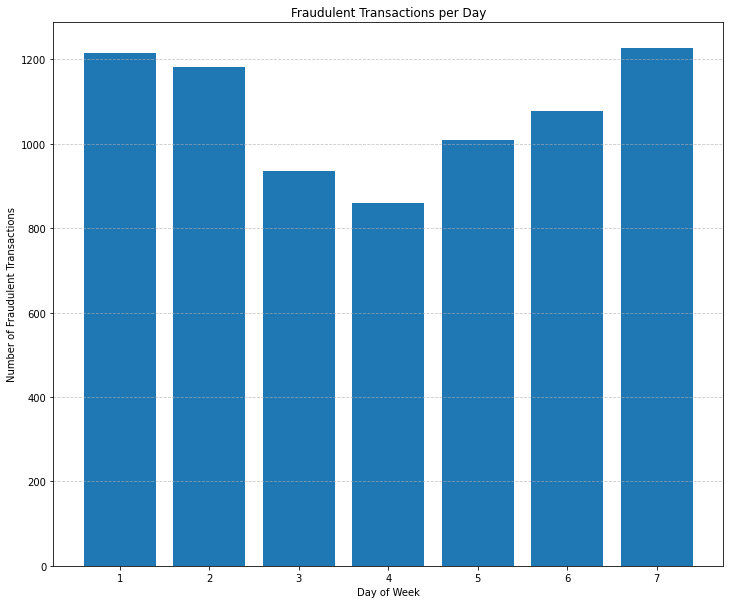

In [0]:
# Set figure size before plotting
plt.figure(figsize=(12, 10))

# Plot the bar chart
plt.bar(data = df_fraud_by_day, x = 'day_of_week', height = 'fraud_count_by_day')
# Show the plot
plt.xlabel("Day of Week")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Fraudulent Transactions per Day")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [0]:
#analyze fraud by year
df_fraud_year = df.filter(col("is_fraud") == 1).groupBy("year").agg(count(col("is_fraud"))\
    .alias("fraud_count_by_year"))
df_fraud_year.sort(col("fraud_count_by_year").desc()).show()
#convert into pandas df
df_fraud_year = df_fraud_year.toPandas()
df_fraud_year.head()


+----+-------------------+
|year|fraud_count_by_year|
+----+-------------------+
|2019|               5220|
|2020|               2286|
+----+-------------------+



,year,fraud_count_by_year
0,2019,5220
1,2020,2286


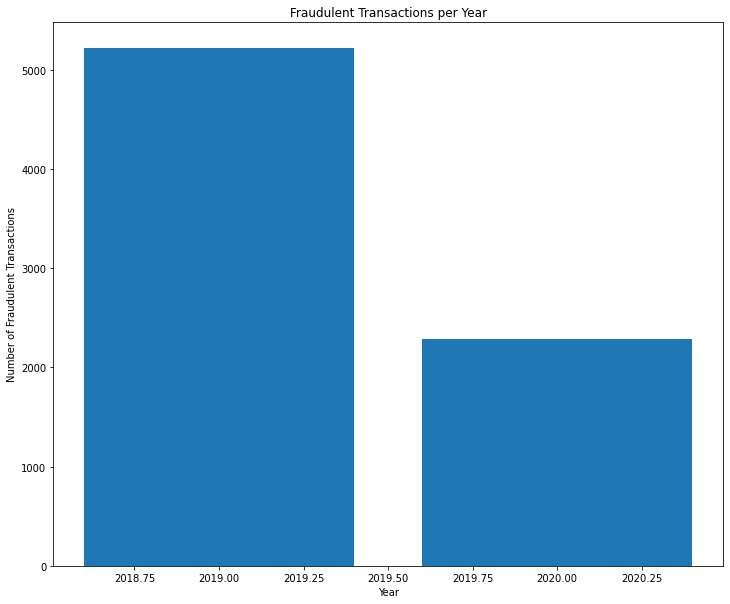

In [0]:
#plot fraud by 
import pandas as pd
import datetime
# Set figure size before plotting
plt.figure(figsize=(12, 10))

# Plot the bar chart
plt.bar(data = df_fraud_year, x = 'year', height = 'fraud_count_by_year')
# Show the plot
plt.xlabel("Year")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Fraudulent Transactions per Year")
plt.show()

In [0]:
#fraud analysis by gender
df.filter(col("is_fraud")==1).groupBy('gender').agg(count(col("is_fraud")))\
    .alias('fraud count by gender').show()

+------+---------------+
|gender|count(is_fraud)|
+------+---------------+
|     F|           3735|
|     M|           3771|
+------+---------------+



In [0]:
# Get summary statistics for all columns in the DataFrame
df.describe().show()


+-------+-----------------+--------------------+-------------------+-------------+-----------------+-------+-------+-------+--------------------+-------+-------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+-----------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|       Unnamed: 0|              cc_num|           merchant|     category|              amt|  first|   last| gender|              street|   city|  state|               zip|              lat|              long|          city_pop|               job|           trans_num|           unix_time|        merch_lat|        merch_long|            is_fraud|    merch_zipcode|       day_of_week|             month|              year|              hour|
+-------+-----------------+--------------------+-------------------+-------------+-----------------+

In [0]:
percentiles = df.approxQuantile("amt", [0.25, 0.75], 0.01)

# Display the results
print(f"25th Percentile: {percentiles[0]}")
print(f"75th Percentile: {percentiles[1]}")

25th Percentile: 9.42
75th Percentile: 82.45


In [0]:
# Basic statistics for amt
df.select(
    mean("amt").alias("mean_amt"),
    stddev("amt").alias("stddev_amt"),
    min("amt").alias("min_amt"),
    max("amt").alias("max_amt")
).show()

# Count of fraud and non-fraud transactions
df.groupBy("is_fraud").agg(
    count("*").alias("transaction_count"),
    mean("amt").alias("avg_amt"),
    stddev("amt").alias("std_amt"),
    min("amt").alias("min_amt"),
    max("amt").alias("max_amt")
).orderBy("is_fraud").show()

+-----------------+-----------------+-------+-------+
|         mean_amt|       stddev_amt|min_amt|max_amt|
+-----------------+-----------------+-------+-------+
|70.35103545606984|160.3160385715272|    1.0|28948.9|
+-----------------+-----------------+-------+-------+

+--------+-----------------+-----------------+------------------+-------+-------+
|is_fraud|transaction_count|          avg_amt|           std_amt|min_amt|max_amt|
+--------+-----------------+-----------------+------------------+-------+-------+
|       0|          1289169|67.66710981259997| 154.0079705460996|    1.0|28948.9|
|       1|             7506|531.3200919264589|390.56006972553587|   1.06|1376.04|
+--------+-----------------+-----------------+------------------+-------+-------+



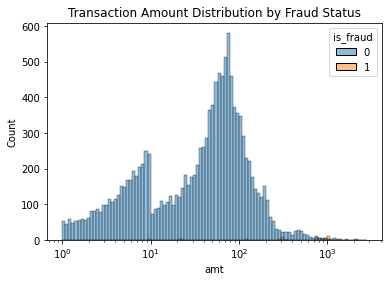

In [0]:
import seaborn as sns

# Downsample and convert to pandas for plotting
sample_df = df.select("amt", "is_fraud").sample(False, 0.01, seed=42).toPandas()

sns.histplot(data=sample_df, x="amt", hue="is_fraud", bins=100, log_scale=True)
plt.title("Transaction Amount Distribution by Fraud Status")
plt.show()


In [0]:
# Unique merchant & category count
df.select(countDistinct("merchant").alias("unique_merchants"),
          countDistinct("category").alias("unique_categories")).show()

# Top 10 most common categories
df.groupBy("category").agg(count("*").alias("transaction_count")) \
  .orderBy(col("transaction_count").desc()) \
  .show(10)

# Fraud rate per category
df.groupBy("category").agg(
    count("*").alias("total_txns"),
    sum("is_fraud").alias("fraud_txns"),
    round((sum("is_fraud") / count("*")) * 100, 2).alias("fraud_rate_percent")
).orderBy(col("fraud_rate_percent").desc()).show(10)

# Top 10 merchants with highest fraud rate (min 100 txns for reliability)
df.groupBy("merchant").agg(
    count("*").alias("total_txns"),
    sum("is_fraud").alias("fraud_txns"),
    round((sum("is_fraud") / count("*")) * 100, 2).alias("fraud_rate_percent")
).filter("total_txns > 100") \
 .orderBy(col("fraud_rate_percent").desc()) \
 .show(10)

+----------------+-----------------+
|unique_merchants|unique_categories|
+----------------+-----------------+
|             693|               14|
+----------------+-----------------+

+--------------+-----------------+
|      category|transaction_count|
+--------------+-----------------+
| gas_transport|           131659|
|   grocery_pos|           123638|
|          home|           123115|
|  shopping_pos|           116672|
|     kids_pets|           113035|
|  shopping_net|            97543|
| entertainment|            94014|
|   food_dining|            91461|
| personal_care|            90758|
|health_fitness|            85879|
+--------------+-----------------+
only showing top 10 rows

+-------------+----------+----------+------------------+
|     category|total_txns|fraud_txns|fraud_rate_percent|
+-------------+----------+----------+------------------+
| shopping_net|     97543|      1713|              1.76|
|     misc_net|     63287|       915|              1.45|
|  grocery_po

In [0]:
#create a binary variable for high risk categories
high_risk_cats = ["shopping_net", "misc_net", "grocery_pos"]
df = df.withColumn("is_high_risk_category", when(col("category").isin(high_risk_cats), 1).otherwise(0))

In [0]:
#create binary variable to indicate high risk merchants
df = df.withColumn("is_flagged_merchant", when(col("merchant").startswith("fraud_"), 1).otherwise(0))


In [0]:
#we can observe all the fraud transactions occur in these flagged merchants(could be data leakage!)
df.groupBy("is_flagged_merchant").agg(
    count("*").alias("count"),
    sum("is_fraud").alias("fraud_count"),
    round((sum("is_fraud") / count("*")) * 100, 2).alias("fraud_rate")
).show()


+-------------------+-------+-----------+----------+
|is_flagged_merchant|  count|fraud_count|fraud_rate|
+-------------------+-------+-----------+----------+
|                  1|1296675|       7506|      0.58|
+-------------------+-------+-----------+----------+



In [0]:
#drop merchant column
df = df.drop("merchant")


In [0]:
#helper function to calculate distance between merchant and users
import math
from pyspark.sql.types import DoubleType

# Define the haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km

    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

# Register UDF
haversine_udf = udf(haversine, DoubleType())

In [0]:
#create distance column
df = df.withColumn(
    "distance_km",
    haversine_udf(col("lat"), col("long"), col("merch_lat"), col("merch_long"))
)

In [0]:
# we can observe fraud rate is equal in both brackets (<100 km distance and >100km distance)
df = df.withColumn(
    "is_distance_suspicious",
    when(col("distance_km") > 100, 1).otherwise(0)
)

df.groupBy("is_distance_suspicious").agg(
    count("*").alias("txn_count"),
    sum("is_fraud").alias("fraud_count"),
    round((sum("is_fraud") / count("*")) * 100, 2).alias("fraud_rate_percent")
).show()


+----------------------+---------+-----------+------------------+
|is_distance_suspicious|txn_count|fraud_count|fraud_rate_percent|
+----------------------+---------+-----------+------------------+
|                     1|   302851|       1747|              0.58|
|                     0|   993824|       5759|              0.58|
+----------------------+---------+-----------+------------------+



In [0]:
#this tells us that all the transactions have taken place in close proximity to the merchants
df.selectExpr("min(distance_km)", "max(distance_km)", "avg(distance_km)").show()



+--------------------+------------------+-----------------+
|    min(distance_km)|  max(distance_km)| avg(distance_km)|
+--------------------+------------------+-----------------+
|0.022254515638533652|152.11717310595034|76.11465060395126|
+--------------------+------------------+-----------------+



In [0]:
#calculating current age of all users and checking fraud rate in different age brackets
df = df.withColumn("age", lit(2020) - year(col("dob")))

df = df.withColumn("age_group", when(col("age") < 25, "<25")
                                 .when((col("age") >= 25) & (col("age") < 35), "25-34")
                                 .when((col("age") >= 35) & (col("age") < 50), "35-49")
                                 .when((col("age") >= 50) & (col("age") < 65), "50-64")
                                 .otherwise("65+"))
df.groupBy("age_group").agg(
    count("*").alias("txn_count"),
    sum("is_fraud").alias("fraud_count"),
    round((sum("is_fraud") / count("*")) * 100, 2).alias("fraud_rate_percent")
).orderBy("age_group").show()


+---------+---------+-----------+------------------+
|age_group|txn_count|fraud_count|fraud_rate_percent|
+---------+---------+-----------+------------------+
|    25-34|   266251|       1399|              0.53|
|    35-49|   445539|       1879|              0.42|
|    50-64|   272439|       2047|              0.75|
|      65+|   216118|       1564|              0.72|
|      <25|    96328|        617|              0.64|
+---------+---------+-----------+------------------+



In [0]:
#calculating user based metrics
from pyspark.sql import Window

user_window = Window.partitionBy("cc_num")

df = df.withColumn("user_txn_count", count("*").over(user_window)) \
       .withColumn("user_total_amt", sum("amt").over(user_window)) \
       .withColumn("user_avg_amt", avg("amt").over(user_window)) \
       .withColumn("user_std_amt", stddev("amt").over(user_window))

In [0]:
#creating binary variable for high spending users and users that show low variance in spending
from pyspark.sql.functions import when

df = df.withColumn("is_high_spender", when(col("user_avg_amt") > 500, 1).otherwise(0)) \
       .withColumn("is_low_variance_spend", when(col("user_std_amt") < 20, 1).otherwise(0))


In [0]:
#chekcing fraud rate by state
df.groupBy("state").agg(
    count("*").alias("txn_count"),
    sum("is_fraud").alias("fraud_count"),
    round((sum("is_fraud") / count("*")) * 100, 2).alias("fraud_rate")
).orderBy(col("fraud_rate").desc()).show(20)


+-----+---------+-----------+----------+
|state|txn_count|fraud_count|fraud_rate|
+-----+---------+-----------+----------+
|   DE|        9|          9|     100.0|
|   RI|      550|         15|      2.73|
|   AK|     2120|         36|       1.7|
|   NV|     5607|         47|      0.84|
|   CO|    13880|        113|      0.81|
|   OR|    18597|        149|       0.8|
|   TN|    17554|        140|       0.8|
|   NE|    24168|        180|      0.74|
|   ME|    16505|        119|      0.72|
|   NH|     8278|         59|      0.71|
|   OH|    46480|        321|      0.69|
|   VA|    29250|        198|      0.68|
|   KS|    22996|        156|      0.68|
|   SC|    29190|        193|      0.66|
|   NY|    83501|        555|      0.66|
|   FL|    42671|        281|      0.66|
|   MN|    31714|        207|      0.65|
|   VT|    11768|         72|      0.61|
|   MD|    26193|        157|       0.6|
|   SD|    12324|         74|       0.6|
+-----+---------+-----------+----------+
only showing top

In [0]:
#create a binary feature indicating high risk states
high_risk_states = ["RI", "AK", "NV", "CO", "OR", "TN"]
df = df.withColumn("is_high_risk_state", when(col("state").isin(high_risk_states), 1).otherwise(0))


In [0]:
#check fraud rates by job title
df.groupBy("job").agg(
    count("*").alias("txn_count"),
    sum("is_fraud").alias("fraud_count"),
    round((sum("is_fraud") / count("*")) * 100, 2).alias("fraud_rate")
).orderBy(col("fraud_rate").desc()).show(20)


+--------------------+---------+-----------+----------+
|                 job|txn_count|fraud_count|fraud_rate|
+--------------------+---------+-----------+----------+
|   Warehouse manager|        7|          7|     100.0|
|  Veterinary surgeon|        8|          8|     100.0|
|Sales promotion a...|       14|         14|     100.0|
|Contracting civil...|        7|          7|     100.0|
|      Engineer, site|       12|         12|     100.0|
|     Legal secretary|       12|         12|     100.0|
|Armed forces tech...|        8|          8|     100.0|
|Broadcast journalist|        9|          9|     100.0|
|              Dancer|       19|         19|     100.0|
|   Personnel officer|       12|         12|     100.0|
|Forest/woodland m...|        9|          9|     100.0|
|Accountant, chart...|       11|         11|     100.0|
|    Industrial buyer|       10|         10|     100.0|
|         Ship broker|        7|          7|     100.0|
|Air traffic contr...|       17|         17|    

In [0]:
df.printSchema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_zipcode: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: i

In [0]:
#drop columns that are not relevant for modeling
cols_to_drop = [
    "Unnamed: 0", "first", "last", "street", "city", "job", "dob", "trans_num",
    "unix_time", "is_flagged_merchant", "is_distance_suspicious", "year",
    "merch_zipcode", "cc_num"  # optional
]
df = df.drop(*cols_to_drop)


In [0]:
#drop state column
df = df.drop("state")


In [0]:
#one-hot encode categorical columns
from pyspark.ml.feature import StringIndexer

# Indexing categorical columns
category_indexer = StringIndexer(inputCol="category", outputCol="category_index")
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
age_group_indexer = StringIndexer(inputCol="age_group", outputCol="age_group_index")

# Apply transformations
df = category_indexer.fit(df).transform(df)
df = gender_indexer.fit(df).transform(df)
df = age_group_indexer.fit(df).transform(df)


In [0]:

#create input feature array using vector assembler
df = df.drop("category", "gender", "age_group")
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    "amt", "city_pop", "lat", "long", "merch_lat", "merch_long",
    "day_of_week", "month", "hour", "distance_km", "age",
    "user_txn_count", "user_total_amt", "user_avg_amt", "user_std_amt",
    "is_high_risk_category", "is_high_spender", "is_low_variance_spend",
    "is_high_risk_state", "category_index", "gender_index", "age_group_index"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)


In [0]:
#divide data into train and test split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
from pyspark.ml.classification import LogisticRegression
#fit logistic model in the data
lr = LogisticRegression(featuresCol="features", labelCol="is_fraud")
model = lr.fit(train_df)
predictions = model.transform(test_df)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#evaluate the logistic model
evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.8380979321337966


In [0]:
# Round logistic regression predictions
predictions = predictions.withColumn("prediction_label", col("prediction").cast("int"))
# True Positive
tp = predictions.filter((col("prediction_label") == 1) & (col("is_fraud") == 1)).count()

# True Negative
tn = predictions.filter((col("prediction_label") == 0) & (col("is_fraud") == 0)).count()

# False Positive
fp = predictions.filter((col("prediction_label") == 1) & (col("is_fraud") == 0)).count()

# False Negative
fn = predictions.filter((col("prediction_label") == 0) & (col("is_fraud") == 1)).count()
# Avoid divide-by-zero
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Confusion Matrix:")
print(f"TP: {tp}, FP: {fp}")
print(f"FN: {fn}, TN: {tn}")
print()
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Confusion Matrix:
TP: 152, FP: 92
FN: 1296, TN: 257302

Precision: 0.6230
Recall:    0.1050
F1 Score:  0.1797


In [0]:
#fit random forest classifier
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="is_fraud",
    numTrees=100,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderROC")
auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {auc:.4f}")

# Cast prediction to int
rf_predictions = rf_predictions.withColumn("prediction_label", col("prediction").cast("int"))

# Confusion matrix components
tp = rf_predictions.filter((col("prediction_label") == 1) & (col("is_fraud") == 1)).count()
fp = rf_predictions.filter((col("prediction_label") == 1) & (col("is_fraud") == 0)).count()
fn = rf_predictions.filter((col("prediction_label") == 0) & (col("is_fraud") == 1)).count()
tn = rf_predictions.filter((col("prediction_label") == 0) & (col("is_fraud") == 0)).count()

# Precision, Recall, F1
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Display results
print(f"Confusion Matrix:")
print(f"TP: {tp}, FP: {fp}")
print(f"FN: {fn}, TN: {tn}\n")

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Random Forest AUC: 0.9903
Confusion Matrix:
TP: 794, FP: 18
FN: 654, TN: 257376

Precision: 0.9778
Recall:    0.5483
F1 Score:  0.7027


In [0]:
#experiment with different probability thresholds 
import numpy as np

# Step 1: Extract fraud probability
get_prob_fraud = udf(lambda v: float(v[1]), DoubleType())
rf_predictions = rf_predictions.withColumn("fraud_prob", get_prob_fraud(col("probability")))

# Step 2: Test multiple thresholds
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]

print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print("-" * 45)

for threshold in thresholds:
    # Apply threshold
    thresholded = rf_predictions.withColumn("custom_prediction", (col("fraud_prob") > threshold).cast("int"))

    # Confusion matrix components
    tp = thresholded.filter((col("custom_prediction") == 1) & (col("is_fraud") == 1)).count()
    fp = thresholded.filter((col("custom_prediction") == 1) & (col("is_fraud") == 0)).count()
    fn = thresholded.filter((col("custom_prediction") == 0) & (col("is_fraud") == 1)).count()

    # Precision, Recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"{threshold:<10.2f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}")

Threshold  Precision  Recall     F1 Score  
---------------------------------------------
0.50       0.9778     0.5483     0.7027    
0.40       0.9613     0.6008     0.7395    
0.30       0.9380     0.7003     0.8019    
0.20       0.8599     0.7756     0.8155    
0.10       0.6226     0.8260     0.7100    


In [0]:
#visualize feature importance
import pandas as pd

# Get list of features (must match order used in VectorAssembler)
feature_cols = [
    "amt", "city_pop", "lat", "long", "merch_lat", "merch_long",
    "day_of_week", "month", "hour", "distance_km", "age",
    "user_txn_count", "user_total_amt", "user_avg_amt", "user_std_amt",
    "is_high_risk_category", "is_high_spender", "is_low_variance_spend",
    "is_high_risk_state", "category_index", "gender_index", "age_group_index"
]

# Extract importance
importances = rf_model.featureImportances.toArray()

# Create DataFrame for easy viewing
importance_df = pd.DataFrame(list(zip(feature_cols, importances)),
                             columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

print(importance_df)


                  Feature  Importance
0                     amt    0.274210
19         category_index    0.174326
8                    hour    0.151134
16        is_high_spender    0.066240
10                    age    0.062164
13           user_avg_amt    0.055713
12         user_total_amt    0.040718
21        age_group_index    0.033525
15  is_high_risk_category    0.031483
11         user_txn_count    0.029752
20           gender_index    0.019590
14           user_std_amt    0.019172
1                city_pop    0.018026
7                   month    0.004577
2                     lat    0.004005
4               merch_lat    0.003923
5              merch_long    0.003342
6             day_of_week    0.002796
3                    long    0.002518
9             distance_km    0.002359
18     is_high_risk_state    0.000428
17  is_low_variance_spend    0.000000


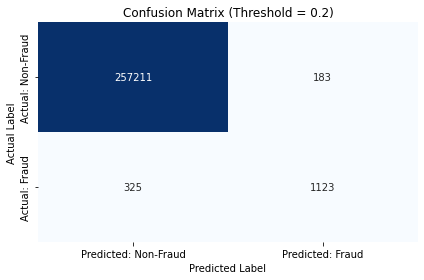

In [0]:
# Extract fraud probability
get_prob_fraud = udf(lambda v: float(v[1]), DoubleType())
rf_predictions = rf_predictions.withColumn("fraud_prob", get_prob_fraud(col("probability")))

# Apply 0.2 threshold
rf_predictions = rf_predictions.withColumn("custom_prediction", (col("fraud_prob") > 0.2).cast("int"))

# Get confusion matrix values
tp = rf_predictions.filter((col("custom_prediction") == 1) & (col("is_fraud") == 1)).count()
fp = rf_predictions.filter((col("custom_prediction") == 1) & (col("is_fraud") == 0)).count()
fn = rf_predictions.filter((col("custom_prediction") == 0) & (col("is_fraud") == 1)).count()
tn = rf_predictions.filter((col("custom_prediction") == 0) & (col("is_fraud") == 0)).count()

# Create confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

cm_df = pd.DataFrame(cm, index=["Actual: Non-Fraud", "Actual: Fraud"],
                        columns=["Predicted: Non-Fraud", "Predicted: Fraud"])

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Threshold = 0.2)")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()
